In [1]:
import os, sys
sys.path.insert(0, '..')

In [6]:
import gensim
import gc
from os.path import join as j
import json
from tqdm import tqdm, trange
from models import glove, custom_trained_model, word2vec
from utils.dataset import PandasDataset
from utils.weat import WEAT
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns, numpy as np, pandas as pd, random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')


gc.enable()

In [3]:
! ls ../input/nyt-10-years

GargWordList.json  embeddings_1941  embeddings_1971  embeddings_2001
embeddings_1921    embeddings_1951  embeddings_1981  embeddings_2011
embeddings_1931    embeddings_1961  embeddings_1991  toy_embed.config


In [4]:
DIR = '../input/nyt-10-years'
YEARS = range(1921, 2021, 10)
EMBEDDINGS_DIR = 'embeddings_{}'
MAN, WOMAN, OCCUPATIONS = 'Man words', 'Woman words', 'Occupations with Human Stereotype Scores'
words = json.load(open(DIR + '/GargWordList.json'))
words[WOMAN].remove('femen')
CSV = "df_{st}_to_{end}.csv"
SCORES = np.zeros(shape=(len(YEARS), 7))
CUSTOM_MODEL_PATH = "../input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin"

In [5]:
class GloveModel(model.Model):
    def __init__(self, embedding_path, dim=100, ):
        super().__init__(load=True, path=embedding_path, dim=dim)
    
    def load(self, path):
        M = Glove().load_model(path)
        self.W = M.W
        self.vocab = M.vocab
        self.D = M.D
        self.X = Glove().load_cooc(j(path, "cooc-C0-V10-W8.bin"), len(M.vocab))
        del M
        gc.collect()
    
    def fit(self): pass
    def transform(self, words, W=None):
        cnt = 0
        ret = np.zeros((len(words), self.D))
        for idx, i in enumerate(words):
            if i in self.vocab:
                ret[idx, :] = self.W[self.vocab[i][0]]
        return ret

In [6]:
def get_bar_plot(y, pred):
    u = np.unique(y)
    classes = len(u)
    match = [0] * classes * 2
    for idx, true in enumerate(y):
        if true == pred[idx]:
            match[true] += 1
        else:
            match[true + classes] += 1
    return pd.DataFrame({'x': list(u) * 2, 'y': match, 'hue': [True] * classes + [False] * classes})

In [7]:
def plot_(x, y, colors, z=None, title="year", three=False, scale=True):
    # https://stackoverflow.com/a/60621783
    sns.set_style("whitegrid", {'axes.grid' : False})
    fig = plt.figure(figsize=(6,6))
    if three:
        ax = Axes3D(fig)
        g = ax.scatter(x, y, z, c=colors, marker='o', depthshade=False, cmap='Paired')
        if scale:
            ax.set_zlim(-1, 1)
            ax.set_xlim(-1, 1)
            ax.set_ylim(-1, 1)
        ax.set_zlabel('Z Label')
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_title(title)
        legend = ax.legend(*g.legend_elements(), loc="lower center", borderaxespad=-10, ncol=4)
        ax.add_artist(legend)
    else:
        plt.scatter(x, y, c=colors)
        if scale:
            plt.xlim(-2, 2)
            plt.ylim(-2, 2)
        plt.title(title)
    plt.show()

In [8]:
def plot_model(model, model_title, man_words, woman_words, occupations=[]):
    
    vecs = model.transform(man_words + woman_words + occupations)
    colors = ['blue'] * len(man_words) + ['pink'] * len(woman_words) + ['green'] * len(occupations)
    
    # plot 3D graph using PCA
    three = PCA(random_state=0).fit_transform(vecs)[:, :3]
    plot_(three[:, 0], three[:, 1], z=three[:, 2], title=model_title + "_3D_PCA", three=True, scale=False, colors=colors)
    
    # plot 2 D plot using PCA
    two = PCA(random_state=0).fit_transform(vecs)[:, :2]
    plot_(two[:, 0], two[:, 1], title=model_title + "_2D_PCA", three=False, scale=False, colors=colors)
    
    
    # plot LDA
    y = np.concatenate([np.zeros(shape=len(man_words), dtype=int), np.ones(dtype=int, shape=len(woman_words)), 
                    np.full(dtype=int, shape=len(occupations), fill_value=2)]) 
    two = LinearDiscriminantAnalysis().fit_transform(vecs, y)
    
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(vecs, y)
    pred = knn.predict(vecs)
    df = get_bar_plot(y=y, pred=pred)
    if len(occupations):
        plot_(two[:, 0], two[:, 1], title=model_title + "_2D_LDA", three=False, scale=False, colors=colors)
    else:
        plot_(two[:, 0], y, title=model_title + "_1D_LDA", three=False, scale=False, colors=colors)
    sns.barplot(data=df, x='x', y='y', hue='hue', ).set_title(model_title + "_KNN classification")
    plt.show()
    return WEAT(model).get_scores()

# PRETRAINED MODEL

In [9]:
m = custom_model.CustomModel(path=CUSTOM_MODEL_PATH, params={"binary": True}, load_method=gensim.models.KeyedVectors.load_word2vec_format)

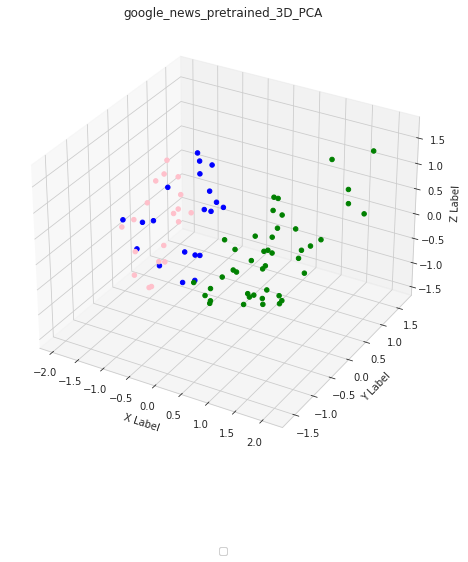

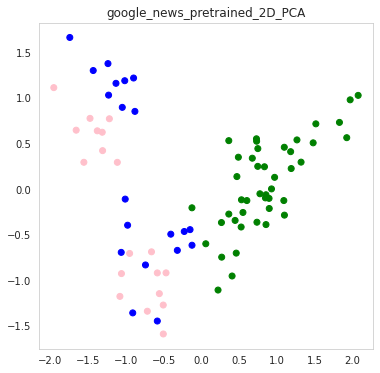

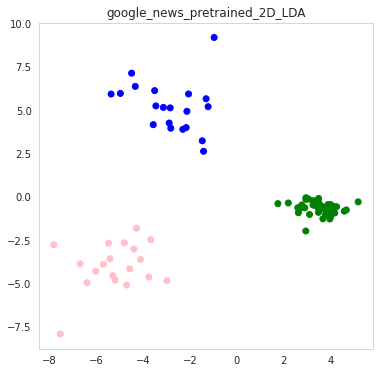

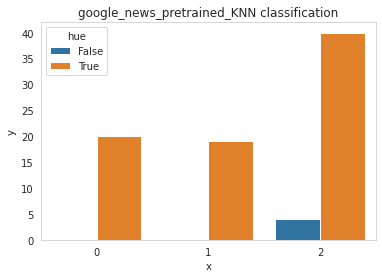

4 words not found in model
41 words not found in model
1 words not found in model
12 words not found in model
1 words not found in model


[-0.8747602,
 -0.43321317,
 1.5281119,
 1.5191028,
 0.9323006,
 1.6142746,
 1.1951628]

In [10]:
plot_model(model=m, model_title="google_news_pretrained", man_words=words[MAN], woman_words=words[WOMAN], occupations=words[OCCUPATIONS])

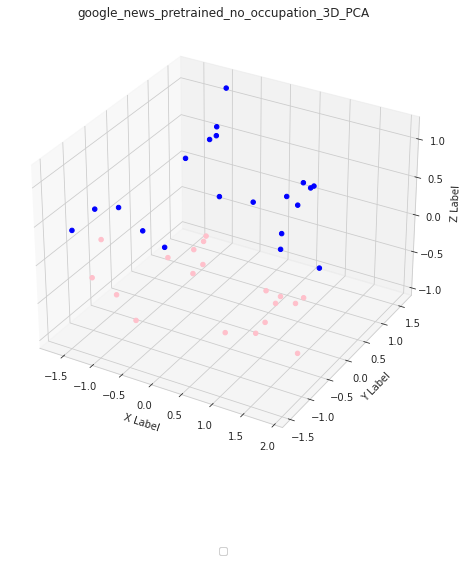

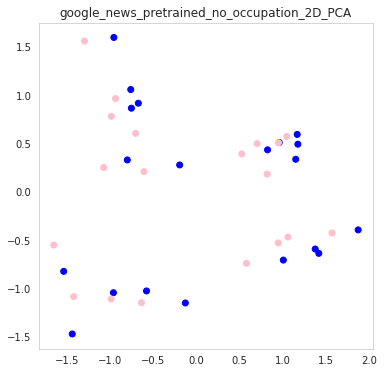

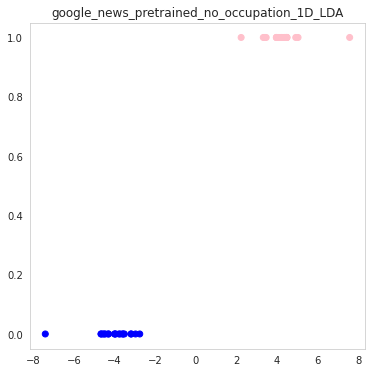

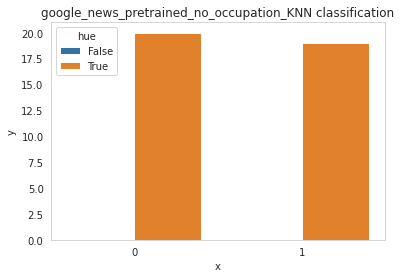

4 words not found in model
41 words not found in model
1 words not found in model
12 words not found in model
1 words not found in model


[-0.8747602,
 -0.43321317,
 1.5281119,
 1.5191028,
 0.9323006,
 1.6142746,
 1.1951628]

In [11]:
plot_model(model=m, model_title="google_news_pretrained_no_occupation", man_words=words[MAN], woman_words=words[WOMAN])

0it [00:00, ?it/s]

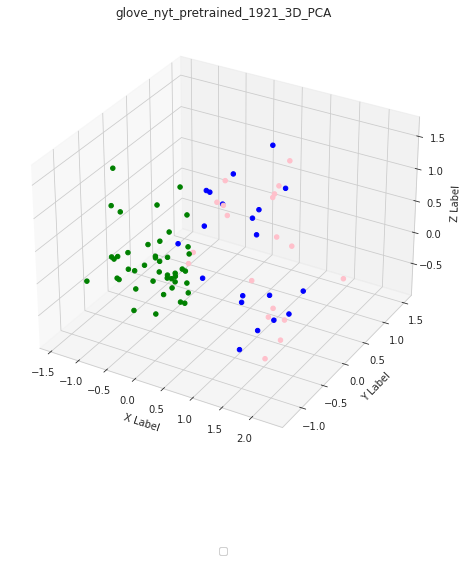

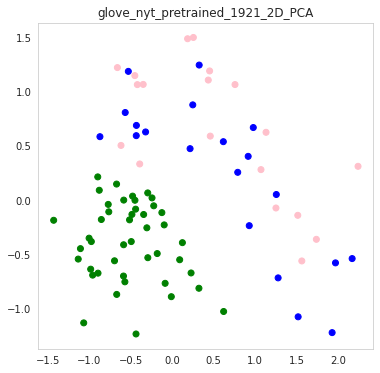

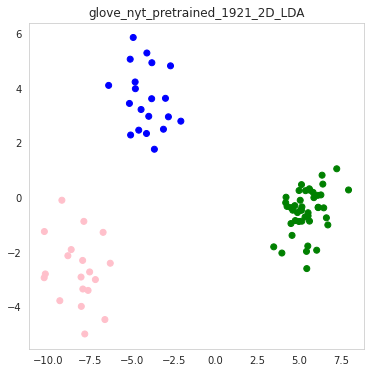

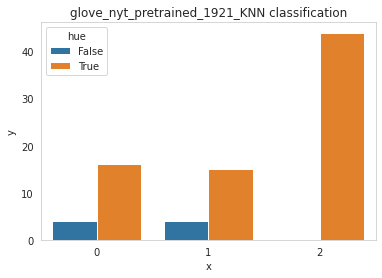

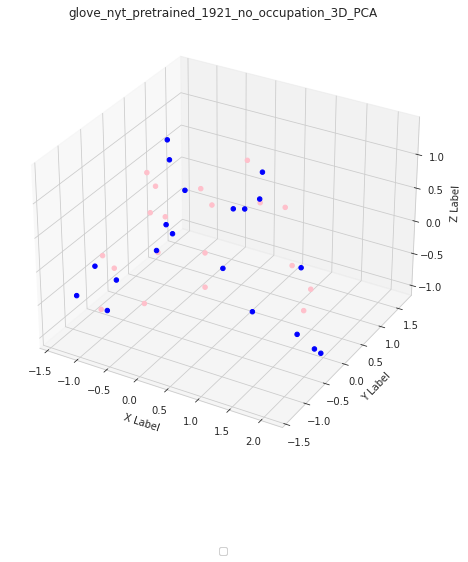

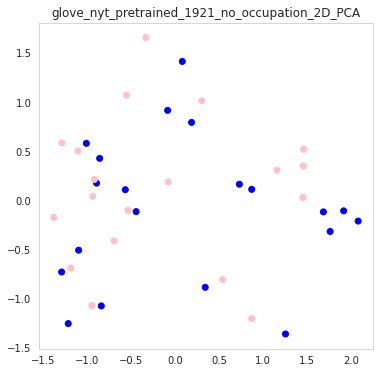

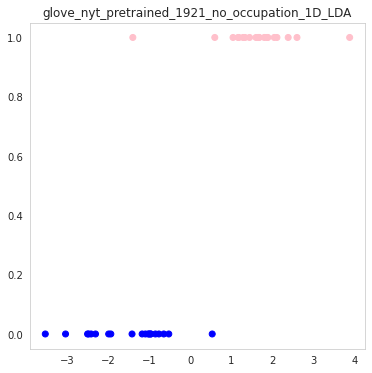

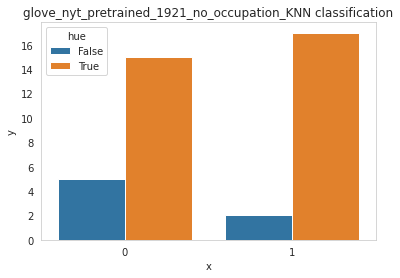

1it [02:12, 132.63s/it]

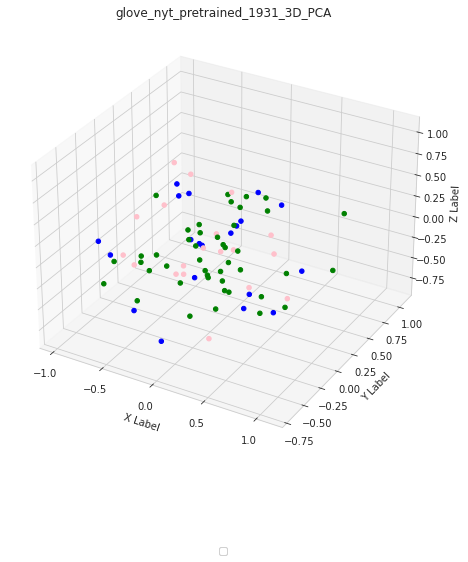

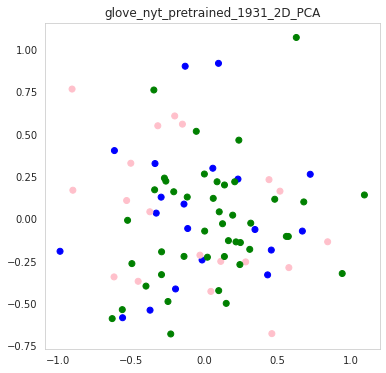

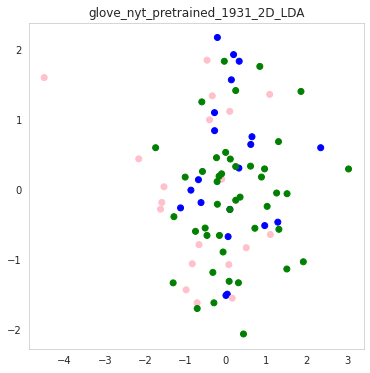

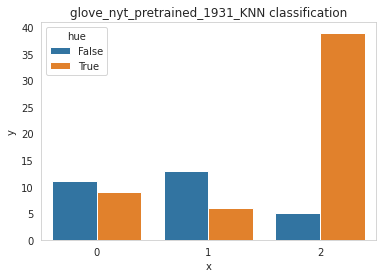

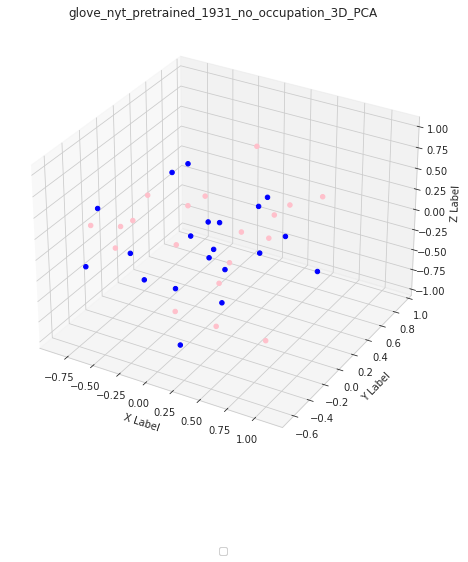

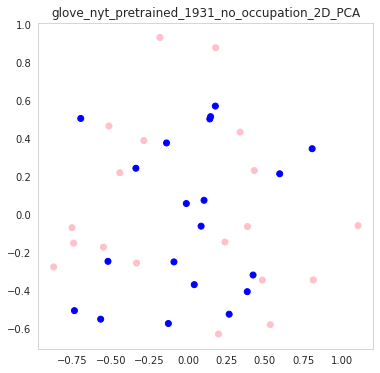

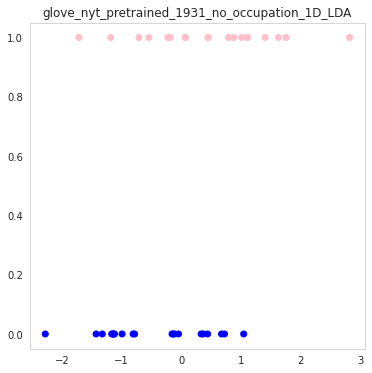

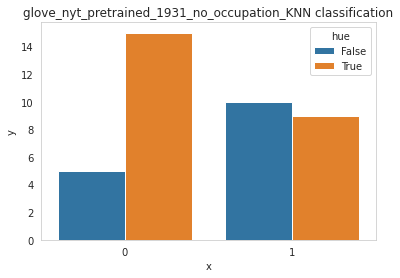

2it [04:20, 129.87s/it]

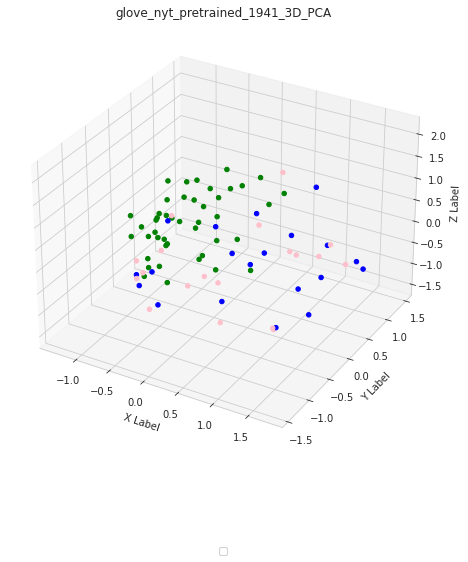

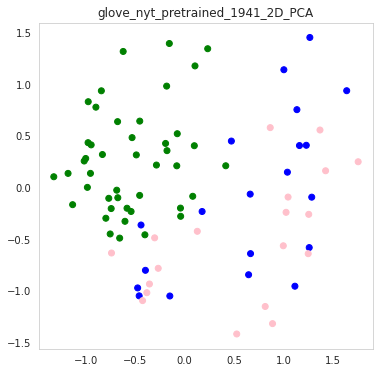

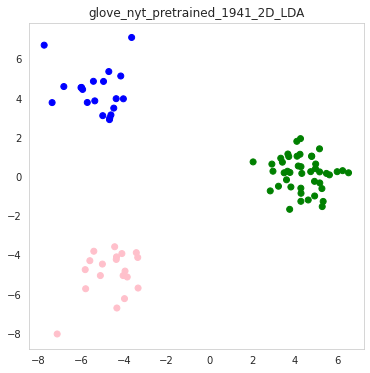

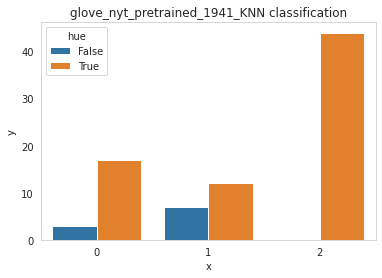

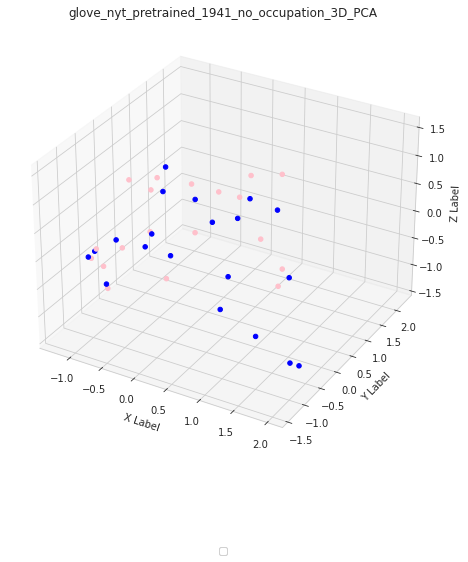

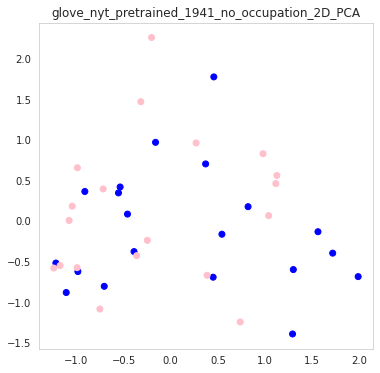

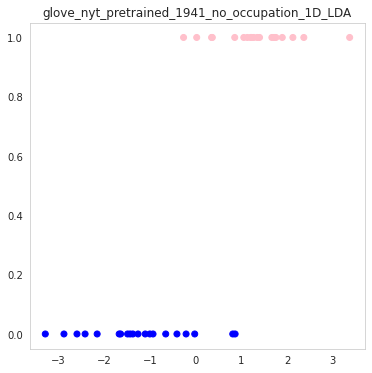

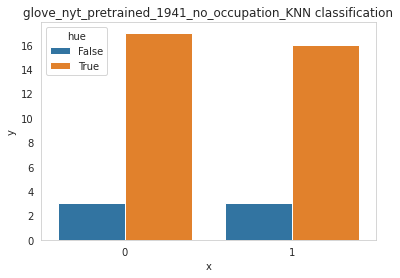

3it [06:41, 135.01s/it]

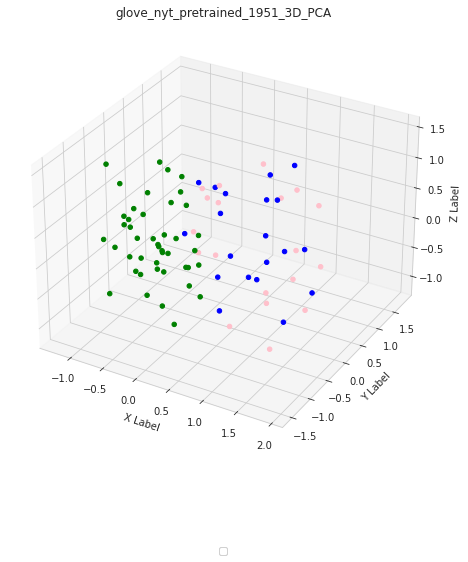

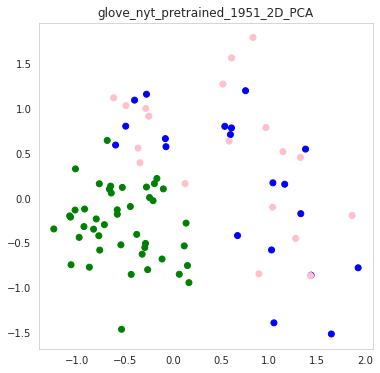

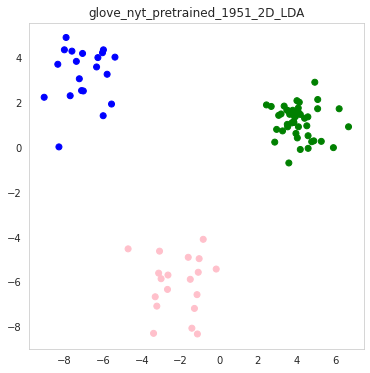

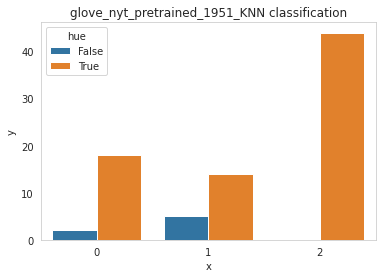

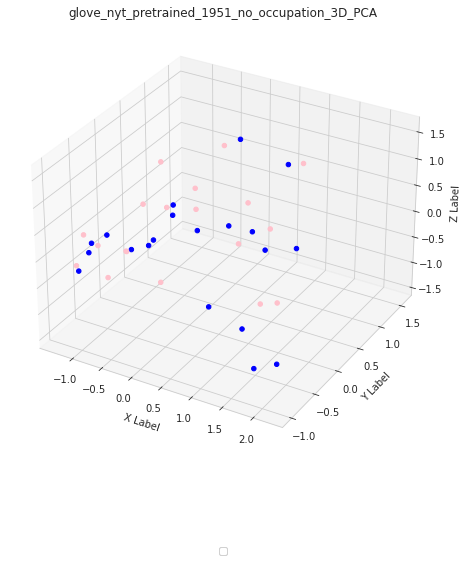

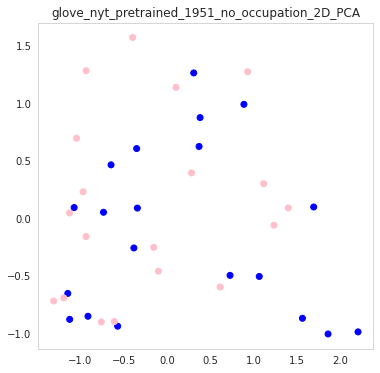

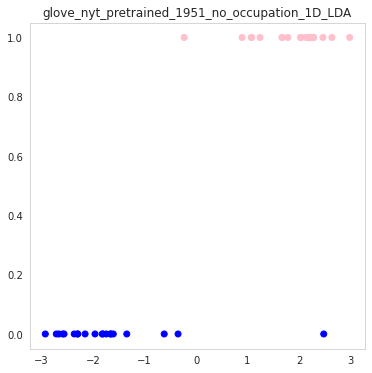

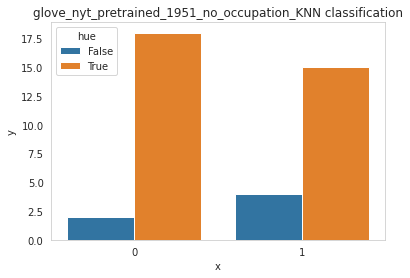

4it [09:13, 141.55s/it]

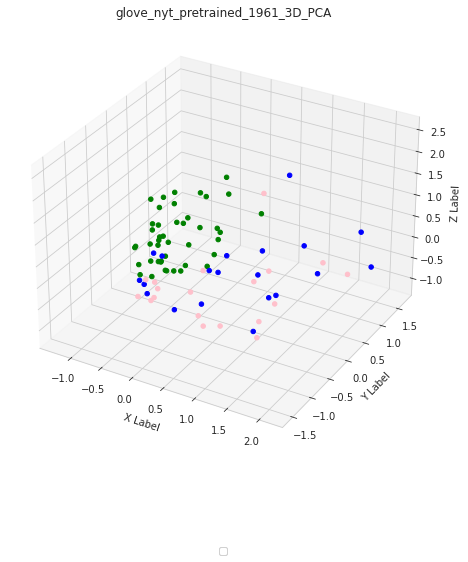

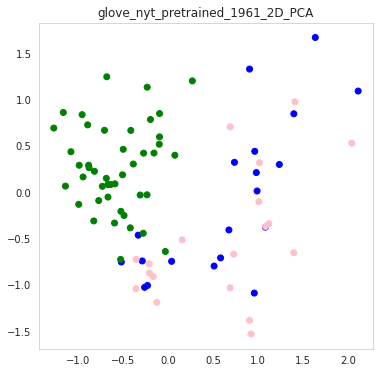

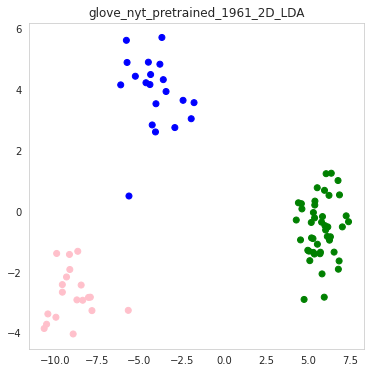

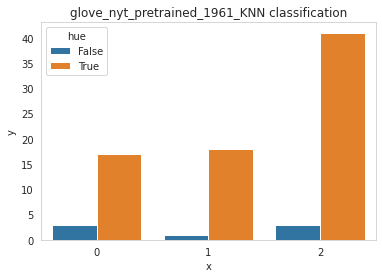

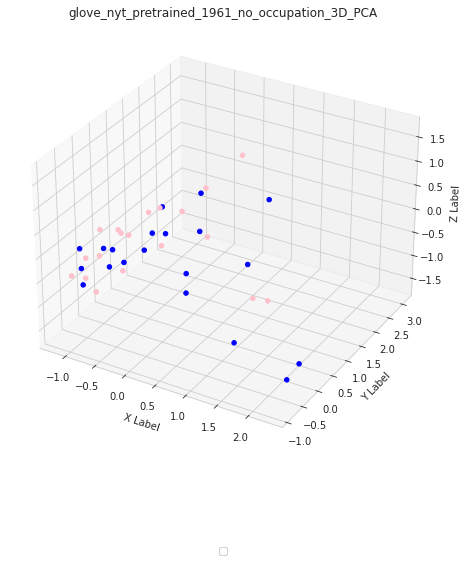

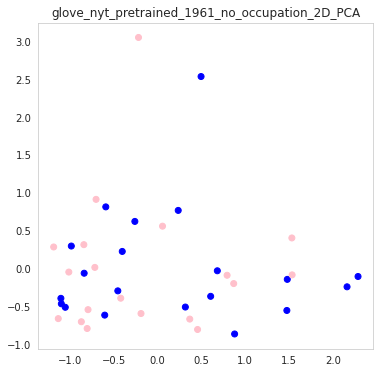

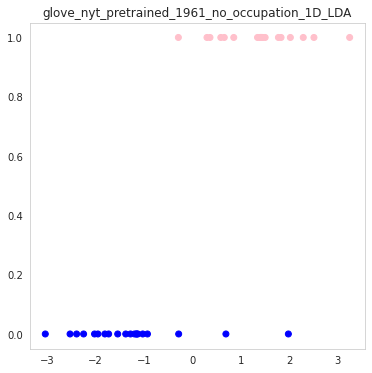

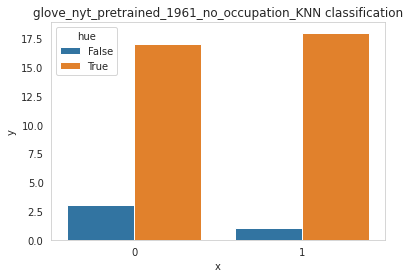

5it [12:00, 150.66s/it]

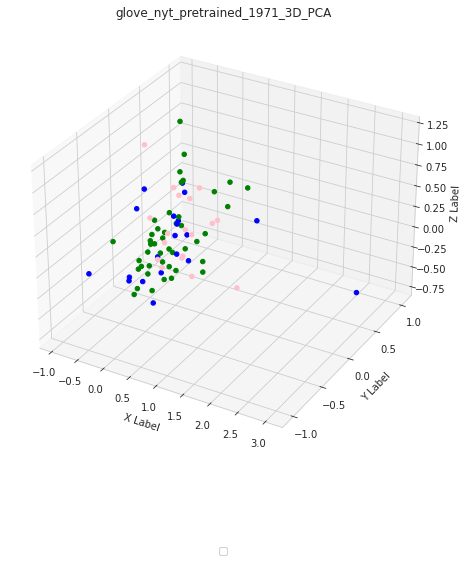

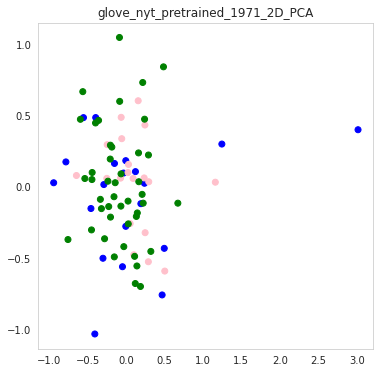

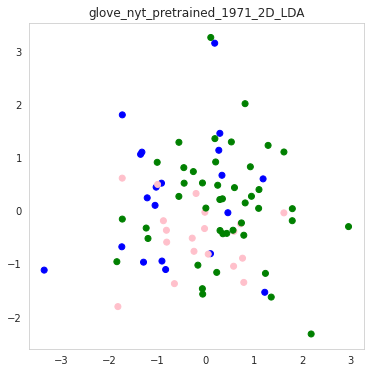

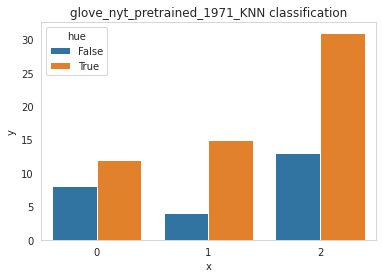

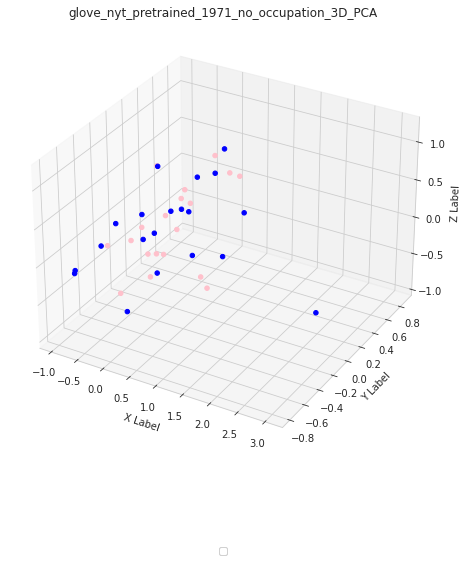

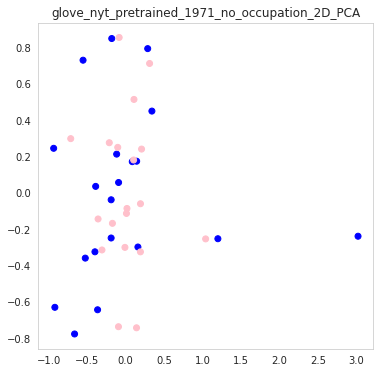

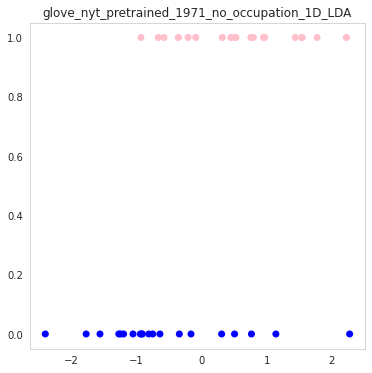

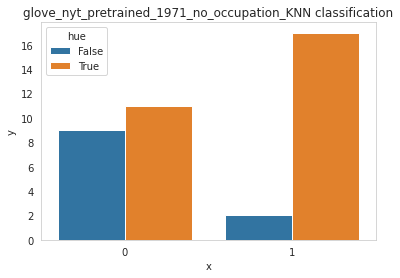

6it [14:23, 148.33s/it]

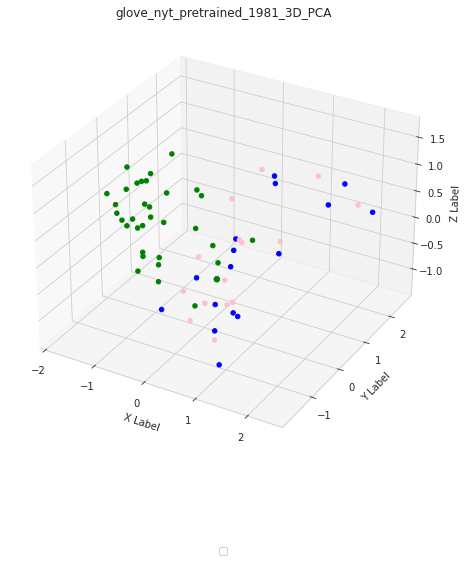

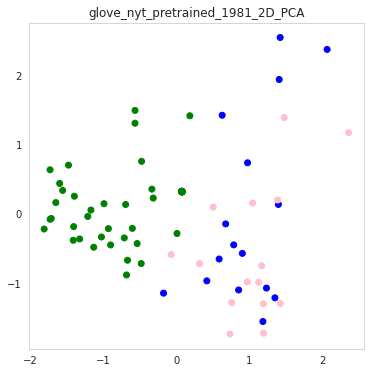

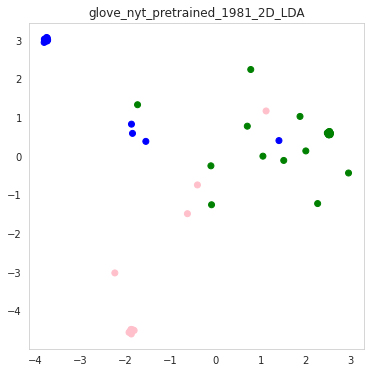

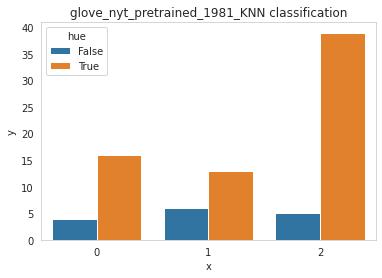

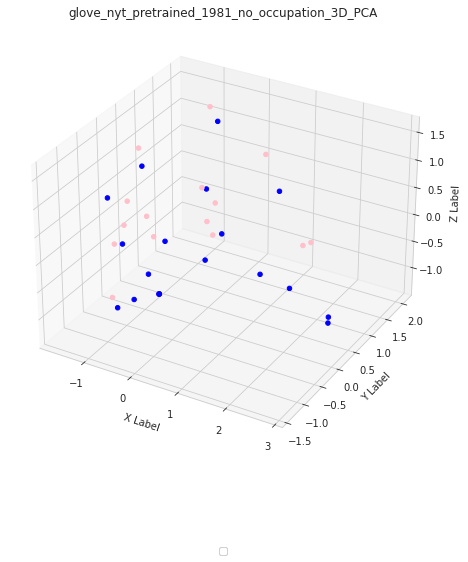

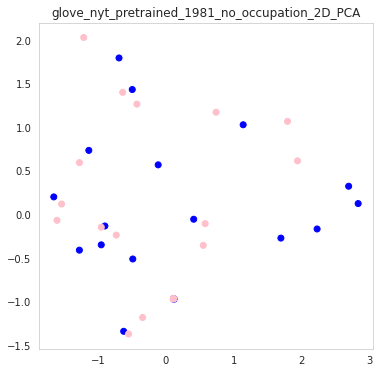

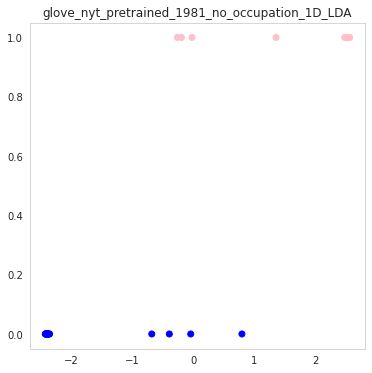

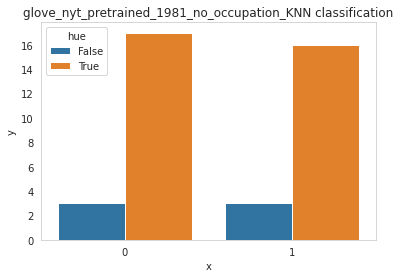

7it [17:15, 155.87s/it]

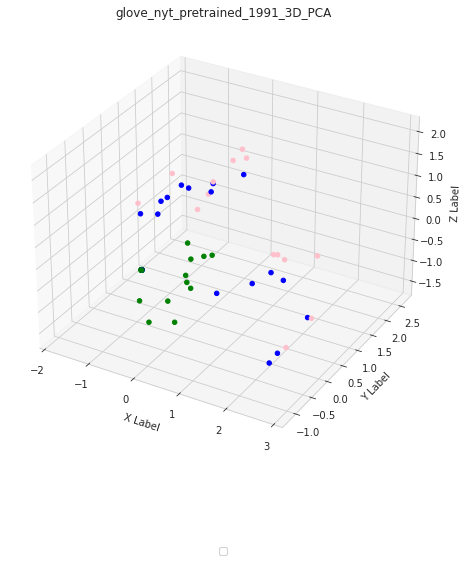

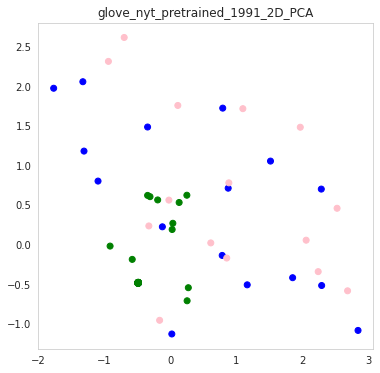

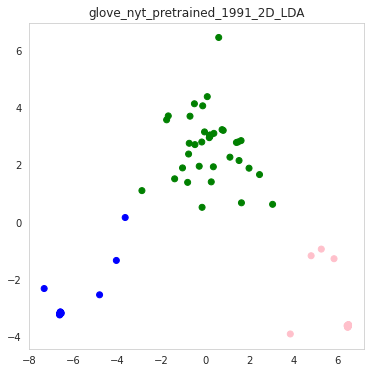

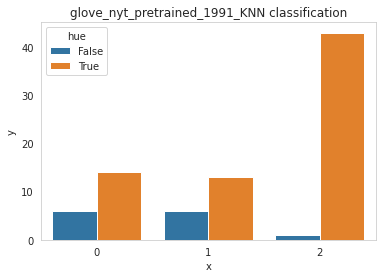

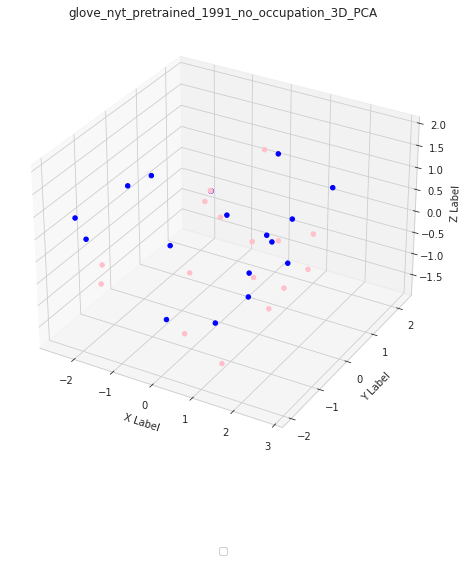

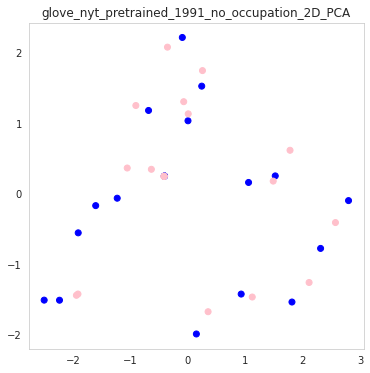

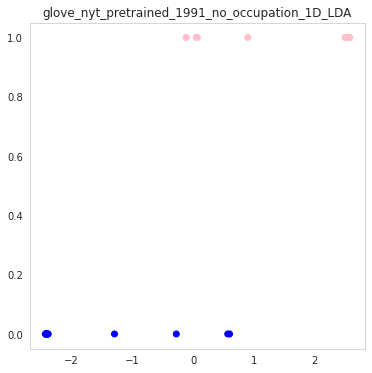

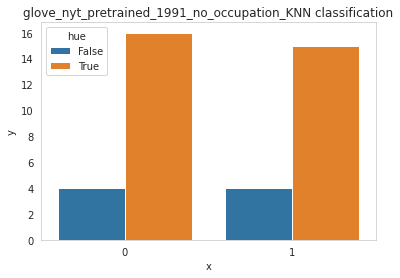

8it [19:23, 147.01s/it]

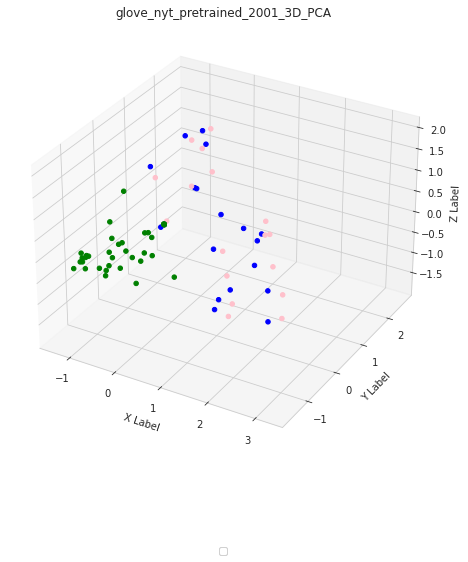

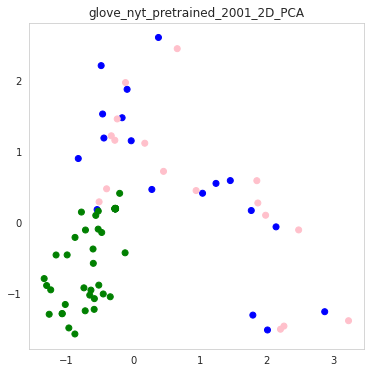

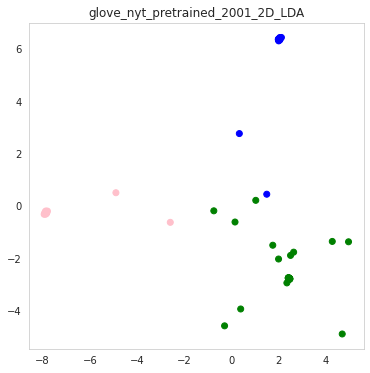

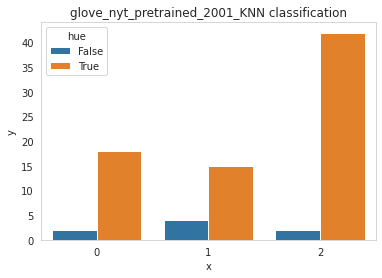

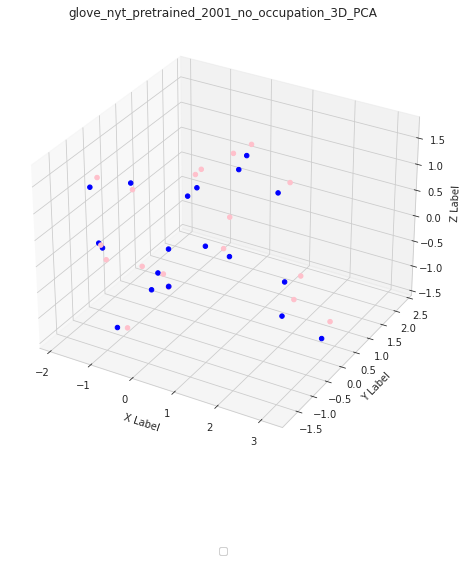

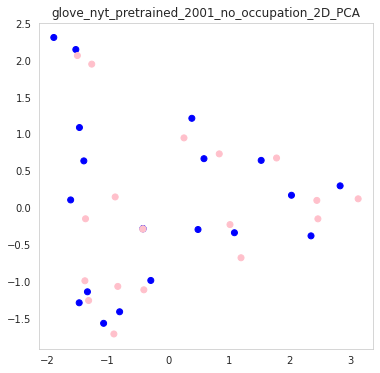

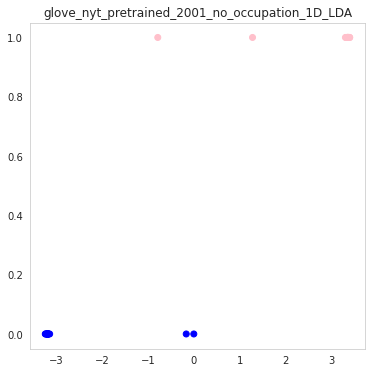

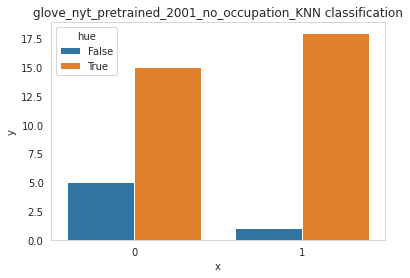

9it [22:32, 160.27s/it]

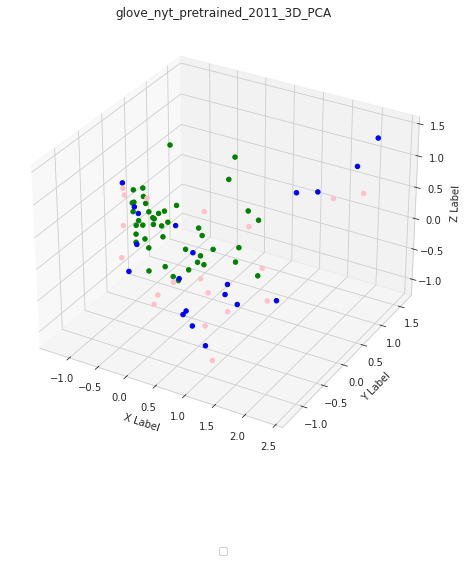

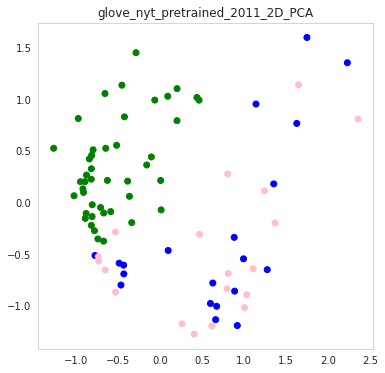

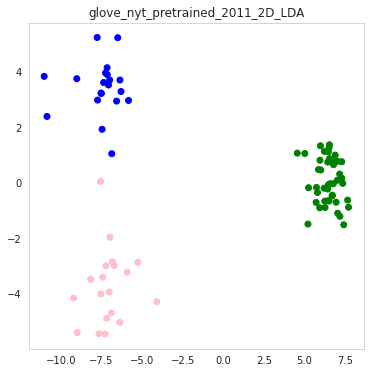

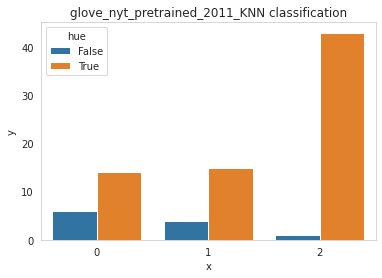

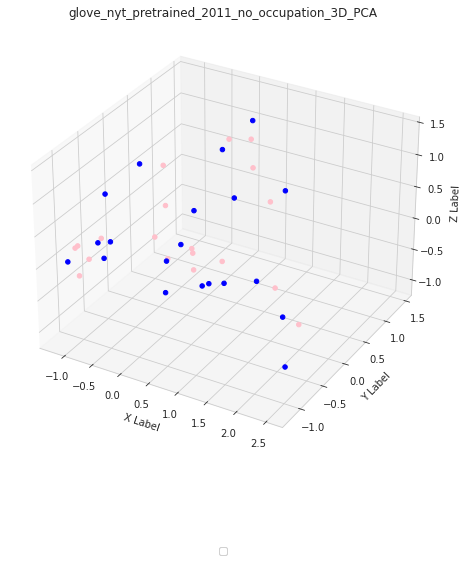

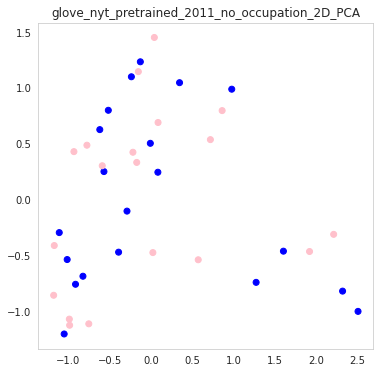

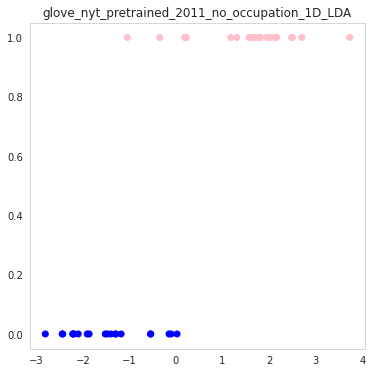

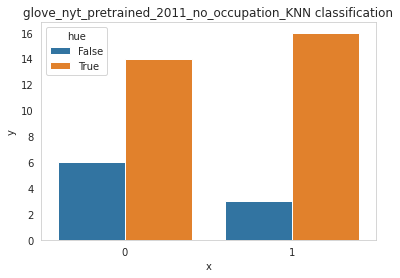

10it [24:20, 146.06s/it]


In [12]:
for idx, y in tqdm(enumerate(YEARS)):
    m = GloveModel(embedding_path=j(DIR, EMBEDDINGS_DIR.format(y)))
    plot_model(model=m, model_title="glove_nyt_pretrained_{}".format(y), man_words=words[MAN], woman_words=words[WOMAN], occupations=words[OCCUPATIONS])
    
    SCORES[idx, :] = plot_model(model=m, model_title="glove_nyt_pretrained_{}_no_occupation".format(y), man_words=words[MAN], woman_words=words[WOMAN])
    del m
    gc.collect()

In [13]:
SCORES

array([[ 0.29076272,  0.18068638,  0.32366077,  1.26862635, -0.82944335,
         0.41270583,  0.29949062],
       [ 0.52677011,  0.17517368, -0.21990042,  0.04750268, -0.06438583,
         0.23810335, -1.28457154],
       [ 0.6369472 ,  1.02794969,  0.83964024,  1.34607805, -0.03227616,
         0.66270445,  0.80510763],
       [ 0.72085942,  0.86704061,  0.88353749,  1.13889175, -0.23703913,
         0.52321246,  0.6751807 ],
       [ 0.90079787,  1.05926819,  0.59143883,  1.58025345, -0.22795586,
         0.88927938,  0.66188709],
       [ 0.06750665, -0.21491808, -0.41287237,  0.15960746, -0.03288093,
         0.13456578, -0.49008308],
       [ 0.25736485,  1.26689473, -0.32997963,  1.83386078,  0.16586554,
         0.68397764, -0.61205843],
       [-0.03395066,  0.36097139, -0.52935787,  1.28822453,  0.74920867,
         0.29423209,  0.40152928],
       [ 0.66642921,  1.63427448,  0.40976078,  1.79635196,  0.30887516,
         0.45901871,  0.49768895],
       [ 0.64592271,  0.6304

In [14]:
df = pd.DataFrame(np.abs(SCORES), columns=["test_{}".format(i) for i in range(7)], index=YEARS)
df.head()

,test_0,test_1,test_2,test_3,test_4,test_5,test_6
1921,0.290763,0.180686,0.323661,1.268626,0.829443,0.412706,0.299491
1931,0.526770,0.175174,0.219900,0.047503,0.064386,0.238103,1.284572
1941,0.636947,1.027950,0.839640,1.346078,0.032276,0.662704,0.805108
1951,0.720859,0.867041,0.883537,1.138892,0.237039,0.523212,0.675181
1961,0.900798,1.059268,0.591439,1.580253,0.227956,0.889279,0.661887


<AxesSubplot:ylabel='test_3'>

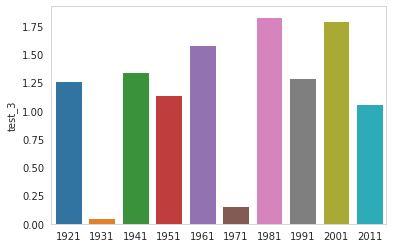

In [15]:
sns.barplot(x=df.index, y=df.test_3)

<AxesSubplot:>

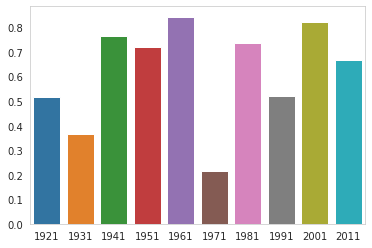

In [16]:
sns.barplot(x=df.index, y=df[["test_{}".format(i) for i in range(7)]].mean(axis=1))

Text(0.5, 1.0, 'year vs number records')

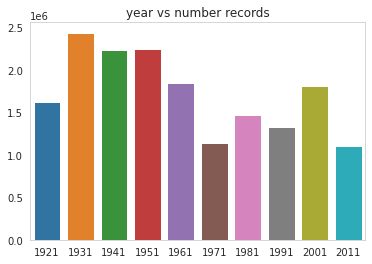

In [17]:
def len_(y): 
    y = y.name
    return pd.read_csv(j(DIR, EMBEDDINGS_DIR.format(y), CSV.format(st=y, end=y + 9))).shape[0]
sns.barplot(x=df.index, y=df.apply(len_, axis=1)).set_title("year vs number records")

In [18]:
! rm -rf *